In [14]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [15]:
import sys
sys.path.append('..')

In [16]:
from tf_unet import image_util_fbp
from tf_unet import unet
from tf_unet import util

In [17]:
generator = image_util_fbp.FBPDataProvider("/home/urota/git/tf_unet/data_64/*.png", data_suffix=".png", mask_suffix="_reconst.png")

Number of files used: 474
Number of channels: 1
Number of classes: 2


In [18]:
x_test, y_test= generator(1)
print(generator.len())

474


(1, 512, 512, 1)
-1.0 0.9921875
-1.0 0.9921875


<Figure size 432x288 with 0 Axes>

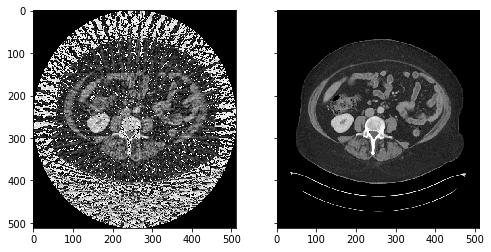

In [19]:
plt.gray()
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
print(y_test.shape)
print(np.min(x_test), np.max(x_test))
print(np.min(y_test), np.max(y_test))
ax[0].imshow(x_test[0, ..., 0], aspect="auto")
ax[1].imshow(y_test[0, ..., 0], aspect="auto")

In [20]:
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, cost="euclidean", layers=5, features_root=32)

Tensor("output_map/conv2d/dropout/mul_1:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("preprocessing/Reshape:0", shape=(?, ?, ?, 1), dtype=float32)


In [21]:
trainer = unet.Trainer(net, optimizer="adam", batch_size=1, opt_kwargs=dict(learning_rate=0.0001))

In [ ]:
path = trainer.train(generator, "./unet_trained64", training_iters=generator.len(), epochs=101, display_step=2, restore=True)

min data: -1.0
max data: 0.9921875
min gt: -1.0
max gt: 0.9921875
min pred: -0.89794755
max pred: 1.2774686
epoch 0


In [8]:
x_test, y_test = generator(1)

prediction = net.predict("../unet_trained64/model.ckpt", x_test)

W0825 09:52:09.093070 140297947583872 deprecation_wrapper.py:119] From ../tf_unet/unet.py:274: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

W0825 09:52:09.966805 140297947583872 deprecation_wrapper.py:119] From ../tf_unet/unet.py:307: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0825 09:52:10.005543 140297947583872 deprecation.py:323] From /home/urota/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


-141.35475817681137
211.86448820392644
-146.6648
215.63345


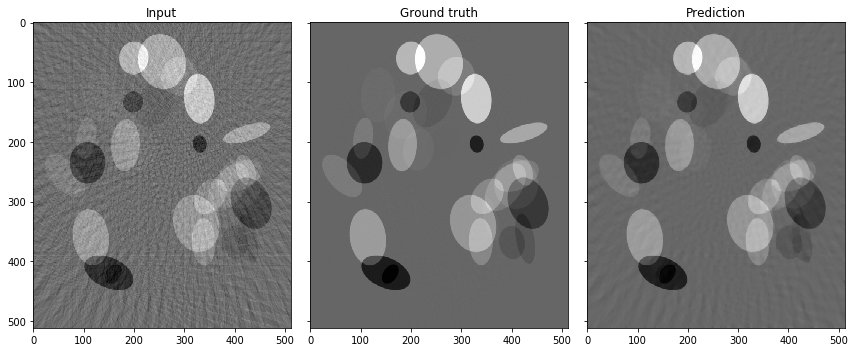

In [9]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,0], aspect="auto")
ax[2].imshow(prediction[0,...,0], aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")
fig.tight_layout()
fig.savefig("../docs/fbp_conv.png")
print(np.min(y_test))
print(np.max(y_test))
print(np.min(prediction))
print(np.max(prediction))

In [40]:
def rsnr(rec, oracle):
    "regressed SNR"
    sumP = sum(oracle.reshape(-1))
    sumI = sum(rec.reshape(-1))
    sumIP = sum(oracle.reshape(-1) * rec.reshape(-1))
    sumI2 = sum(rec.reshape(-1)**2)
    A = np.matrix([[sumI2, sumI], [sumI, oracle.size]])
    b = np.matrix([[sumIP], [sumP]])
    c = np.linalg.inv(A)*b  # (A)\b
    rec = c[0, 0]*rec+c[1, 0]
    err = sum((oracle.reshape(-1)-rec.reshape(-1))**2)
    SNR = 10.0*np.log10(sum(oracle.reshape(-1)**2)/err)

    if np.isnan(SNR):
        SNR = 0.0
    return SNR

print(rsnr(y_test, prediction))

import skimage
print(y_test.dtype, y_test.shape)
print(prediction.dtype, prediction.shape)
y_min = np.min(y_test)
p_min = np.min(prediction)
y_max = np.max(y_test)
p_max = np.max(prediction)
print(y_min, p_min, y_max, p_max)
mi = min(y_min, p_min)
ma = max(y_max, p_max)

def normalize(img):
  return img.reshape(512, 512) / 512. + .5

x_n = normalize(x_test)
y_n = normalize(y_test)
p_n = normalize(prediction)
print(skimage.measure.compare_psnr(y_n, p_n))
print(skimage.measure.compare_ssim(y_n, p_n))

print(skimage.measure.compare_psnr(x_n, y_n))
print(skimage.measure.compare_ssim(x_n, y_n))

20.96707525398349
float64 (1, 512, 512, 1)
float32 (1, 512, 512, 1)
-141.35475817681137 -146.6648 211.86448820392644 215.63345
42.73544952237977
0.992308352473543
30.710572510652522
0.8471783422279248


512
512
<generator object _iter_bytes_to_values at 0x7fc6857db1e0>
int32
29744
33970
#
-3024
1202
0.0
255.0


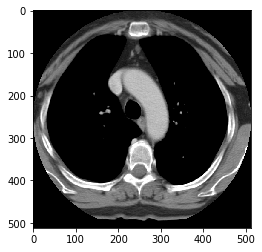

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import png
import numpy as np
from sklearn.preprocessing import minmax_scale
plt.gray()

#reader = png.Reader("/mnt/collect/ct_images/Images_png/000086_04_01/079.png")
reader = png.Reader("/mnt/collect/ct_images/Images_png/000001_01_01/109.png")
pngdata = reader.read()
print(pngdata[0])
print(pngdata[1])
print(pngdata[2])
px_array = np.array(map(np.int32, pngdata[2]))
print(px_array.dtype)
print(np.min(px_array))
print(np.max(px_array))

normalized = px_array - 32768
print("#")
print(np.min(normalized))
print(np.max(normalized))

def intensity_windowing(img, a, b):
    # return img
    assert(a < b)
    return np.minimum(255, np.maximum(0, ((img.astype("float") - a) / (b - a)) * 255))

def show_histogram(img):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(normalized, bins=50)
    fig.show()

normalized = intensity_windowing(normalized, -175, 275)

print(np.min(normalized))
print(np.max(normalized))
plt.imshow(normalized.astype("uint8"))

((512, 64), dtype('float64'))
(0.0, 66944.86666666671)


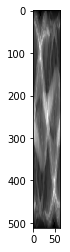

In [115]:
from skimage.transform import radon
import mlem

#shape = (256, 512)
#sino = mlem.mlem.forward_projection(normalized, shape)

theta = np.linspace(0., 360., 64, endpoint=False)
sino = radon(normalized, theta=theta, circle=True)
print(sino.shape, sino.dtype)
print(np.min(sino), np.max(sino))
plt.imshow(sino)

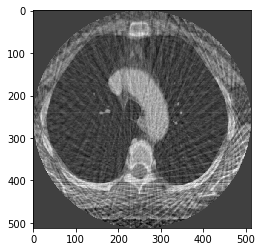

In [116]:
from skimage.transform import iradon

fbp = iradon(sino, theta=theta, circle=True)
plt.imshow(fbp)